In [89]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

from xclim.indices.stats import fit
from scipy.stats import norm, gamma

from xclim.indicators.atmos import drought_code

rnm = "socal-baja"

# import rioxarray as rxr

In [3]:
xn, xx, yn, yx = [-125,-110,30,40]
sf = gpd.read_file("sf_socal-baja").to_crs(epsg = 4326)

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

In [25]:
def awmean(da, to_sf, da_crs = "EPSG:4326"):
    
    da = da.rio.write_crs(da_crs)
    da = da.rio.clip(to_sf.geometry.values, to_sf.crs, all_touched = True)
    
    # get area weights
    if "rlat" in da.dims:
        lats = da.rlat.data
        lons = da.rlon.data
        xydims = ["rlat", "rlon"]
    elif "x" in da.dims:
        lats = da.y.data
        lons = da.x.data
        xydims = ["x", "y"]
    else:
        lats = da.lat.data
        lons = da.lon.data
        xydims = ["lat", "lon"]        
    
    lat_width = np.abs(lats[1] - lats[0]) / 2
    lon_width = np.abs(lons[1] - lons[0]) / 2
    
    area_weights = np.zeros_like(da.isel(time = 0))
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            cell = Polygon([(lon + lon_width, lat + lat_width),
                            (lon - lon_width, lat + lat_width),
                            (lon - lon_width, lat - lat_width),
                            (lon + lon_width, lat - lat_width)])
            area_weights[i,j] = cell.intersection(to_sf.geometry).area / cell.area
    area_weights = xr.DataArray(data = area_weights, dims = da.isel(time = 0).dims, coords = da.isel(time = 0).coords)
            
    weighted_da = da.weighted(area_weights).mean(xydims).rename("dc").reset_coords(drop = True)

    return weighted_da

In [5]:
def hydro_days(ds):
    
    hydro_yrs = []
    for yr in range(int(ds.time.dt.year.min()), int(ds.time.dt.year.max())):
        temp = ds.dc.sel(time = np.logical_or(
            np.logical_and(ds.time.dt.year == yr, ds.time.dt.month >= 9),
            np.logical_and(ds.time.dt.year == yr+1, ds.time.dt.month <= 8)))
#         temp = temp.mean(dim = ['latitude','longitude'])
        hydro_yrs.append(temp)
    
    hydro_doys = []
    for i, data in enumerate(hydro_yrs):
        temp = data.rolling(time = 7).mean()#.resample(time = 'W').mean()
        drop = list([np.nan]*7) + list(temp.data[7:] - temp.data[:-7])
        min_arg = np.nanargmin(drop)
        doy_hydro = int(temp.time[min_arg].dt.dayofyear)
        start_doy = int(data.time[0].dt.dayofyear)
        if doy_hydro >= start_doy:
            output = doy_hydro - start_doy
        else:
            eoy = pd.to_datetime(f'{int(temp.time.dt.year[0])}-12-31').dayofyear
            output = (eoy - start_doy) + doy_hydro
        hydro_doys.append(output)

    yrs = np.arange(int(ds.time.dt.year.min()), int(ds.time.dt.year.max()))
    
    df = pd.DataFrame(
        np.array([yrs, hydro_doys]).T,
        columns = ["year", "dc_doy"])
    df = df.set_index("year")
    return df

---
# CDS download requests

In [3]:
import os, cdsapi
from IPython.display import clear_output

client = cdsapi.Client()

ModuleNotFoundError: No module named 'cdsapi'

## Noon FWI variables - ERA5

In [3]:
for y in range(2024,1949,-1):
        
        y = str(y)
        
        new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5/era5_noon-vars_"+y+".nc"
        print(y)
        if os.path.exists(new_fnm): continue
                
        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_dewpoint_temperature",
                "2m_temperature"
            ],
            "year": [y],
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": ["20:00"],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [40, -125, 30, -110]
        }

        client.retrieve(dataset, request, new_fnm)
        
clear_output(wait = False)
print("Done.")

Done.


## 24h accumulated precip - ERA5

In [1]:
for y in range(2023,1950,-1):
        
        y = str(y)
        
        new_fnm = "/rds/general/user/cb2714/projects/wwa/ephemeral/cali-wildfires/era5/era5_pr24h_"+y+".nc"
        print(y)
        if os.path.exists(new_fnm): continue
        
        dataset = "derived-era5-single-levels-daily-statistics"
        request = {
            "product_type": "reanalysis",
            "variable": ["total_precipitation"],
            "year": y,
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "daily_statistic": "daily_sum",
            "time_zone": "utc-08:00",
            "frequency": "1_hourly",
            "area": [40, -125, 30, -110],
            'format': 'netcdf'
        }

        client.retrieve(dataset, request, new_fnm)
        clear_output(wait = False)
        
print("Done.")

2023


NameError: name 'os' is not defined

## Hourly VPD variables - ERA5Land

In [ ]:
for y in range(1980,1949,-1):
    for m in range(1,13):

        y = str(y)
        m = str(m).rjust(2,"0")
        new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5land/era5land_vpd-vars_"+y+"-"+m+".nc"
        print(y+m)
        if os.path.exists(new_fnm): continue

        dataset = "reanalysis-era5-land"
        request = {
        "variable": [
            "2m_dewpoint_temperature",
            "2m_temperature",
            "10m_u_component_of_wind",
            "10m_v_component_of_wind"
        ],
        "year": y,
        "month": m,
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "time": [
            "00:00", "01:00", "02:00",
            "03:00", "04:00", "05:00",
            "06:00", "07:00", "08:00",
            "09:00", "10:00", "11:00",
            "12:00", "13:00", "14:00",
            "15:00", "16:00", "17:00",
            "18:00", "19:00", "20:00",
            "21:00", "22:00", "23:00"
        ],
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": [40, -125, 30, -110]
        }
        client.retrieve(dataset, request, new_fnm)
        clear_output(wait = False)

print("Done.")

196801


2025-01-13 11:01:11,581 INFO [2025-01-09T00:00:00] Please be aware that ERA5 data from 1st January 2025 was degraded and is being corrected. Watch the [Forum announcement](https://forum.ecmwf.int/t/era5-data-from-1st-january-2025-was-degraded-and-is-being-corrected/10689) for updates.
2025-01-13 11:01:11,582 INFO Request ID is d64941a3-fc47-4b47-b868-4e512e08db07
2025-01-13 11:01:11,633 INFO status has been updated to accepted
2025-01-13 11:03:05,725 INFO status has been updated to running


---
# MSWX FWI

## Extract FWI variables

In [74]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/"

In [21]:
for y in range(2024, 2026):
    print(y, end = " ")
    
    for varnm in ["P", "RelHum", "Tmax", "Wind"]:
        
        new_fnm = outpath+varnm+"_"+str(y)+".nc"
        if os.path.exists(new_fnm): continue
            
        print(varnm, end = " ")
        
        da = wrap_lon(xr.open_mfdataset(fpath+varnm+"/"+str(y)+"/*.nc")).sel(lon = slice(xn,xx), lat = slice(yn,yx))
        da.to_netcdf(new_fnm)
    print("")

2024 
2025 P RelHum Tmax Wind 


## Compute FWI

In [75]:
from xclim.indicators.atmos import cffwis_indices

# compile all the variables
# ds = xr.merge([xr.open_mfdataset([fnm for fnm in glob.glob(outpath+"*"+varnm+"*.nc") if fnm[-7:-3] >= "2024"]) for varnm in ["P", "RelHum", "Tmax", "Wind"]]).load()  # 2024-25 only
ds = xr.merge([xr.open_mfdataset(outpath+"*"+varnm+"*.nc") for varnm in ["P", "RelHum", "Tmax", "Wind"]]).load()
ds = ds.rename(precipitation = "pr", relative_humidity = "hurs", air_temperature = "tas", wind_speed = "sfcWind")

# mask to land surface only
ds = ds.where(regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds) == 0)

fwi = cffwis_indices(ds = ds, overwintering = False)
fwi = xr.merge(fwi)

fwi.to_netcdf(outpath+"fwi_mswx_1979-2025.nc")

## Daily time series

In [103]:
da = fwi.rio.write_crs(sf.crs).rename(lat = "y", lon = "x")
da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["x", "y"]).reset_coords(drop = True)
for varnm in list(da_ts.data_vars): da_ts[varnm].to_netcdf("data/mswx_"+varnm+"_"+rnm+".nc")

# Compile VPD variables

In [ ]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

In [13]:
fl = sorted(glob.glob(fpath+"era5land/era5land_vpd-vars_*.nc"))
fl = [fnm for fnm in fl if int(fnm[-10:-6]) >= 1970]

In [14]:
ds = wrap_lon(xr.open_mfdataset(fl))
ds = ds.reset_coords(drop = True).rename(valid_time = "time")

In [16]:
d2m = convert_units_to(ds.d2m, "degC").load()
t2m = convert_units_to(ds.t2m, "degC").load()
        
vpd = np.exp(17.25*t2m / (243.04 + t2m)) - np.exp(17.25*d2m / (243.04 + d2m))
vpd_max = vpd.resample(time = "D").max().rename("vpd")

tas_max = t2m.resample(time = "D").max()

wspd = (np.sqrt(ds.u10**2 + ds.v10**2)).rename("sfcWind")
wspd_max = wspd.resample(time = "D").max()

In [17]:
vpd_max.to_netcdf(fpath+"era5-land_vpdmax_197001-198012.nc")
tas_max.to_netcdf(fpath+"era5-land_tasmax_197001-198012.nc")
wspd_max.to_netcdf(fpath+"era5-land_sfcWindmax_197001-198012.nc")

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


---
# Get time series - obs

## Nino indices

### Detrended Nino3.4

Use monthly mean SST from 20S:20N to detrend [Nino3.4](https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a&STATION=NINO3.4&TYPE=i&id=someone@somewhere)

In [92]:
# download latest SST data from ERSST
! wget https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc
clear_output(wait = False)

In [2]:
ersst = wrap_lon(xr.open_dataset("sst.mnmean.nc").sst)

# quick method for area-weighted averaging (will add to WWA main but need to generalise dims first)
def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])

In [123]:
nino34 = awmean(ersst.sel(lat = slice(-5,5), lon = slice(-170,-120)))
sst_tropical = awmean(ersst.sel(lat = slice(-20,20)))

nino34_det = (nino34 - sst_tropical).rename("nino34")
nino34_det.to_netcdf("data/ersst_nino34_detrended.nc")

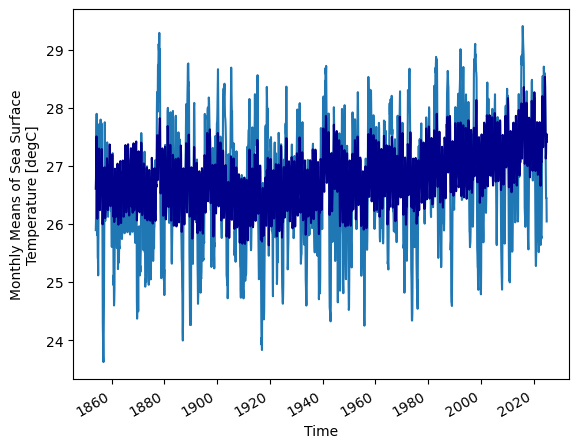

In [116]:
nino34.plot()
sst_tropical.plot(color = "darkblue")

### Nino modoki

$EMI = SST_{C} - 0.5SST_E - 0.5SST_W$

where
$SST_C$ is the SST anomaly from 10S-10N, 165W-140W; $SST_E$ is the SST anomaly from 10S-20N, 125E-145E; and $SST_W$ is the SST anomaly from 15S-5N, 110W-70W.


In [11]:
sst_c = ersst.sel(lat = slice(-10,10), lon = slice(-145,165))
sst_e = ersst.sel(lat = slice(-10,20), lon = slice(125,145))
sst_w = ersst.sel(lat = slice(-15,5), lon = slice(-110,-70))

In [12]:
sst_c_ts = sst_c.mean(["lat", "lon"])
sst_e_ts = sst_e.mean(["lat", "lon"])
sst_w_ts = sst_w.mean(["lat", "lon"])

In [ ]:
emi = sst_c_ts - (0.5 * sst_e_ts) - (0.5 * sst_w_ts)
emi.to_dataframe().to_csv("data/nino-modoki.csv")

# OND indices

In [16]:
nino34 = xr.open_dataset("data/ersst_nino34_detrended.nc").nino34

nino34_ond = nino34.rolling(time = 3).mean().groupby("time.month")[12]
nino34_ond.assign_coords(time = nino34_ond.time.dt.year).rename("nino34_ond", time = "year").to_dataframe().to_csv("ts/nino34_ond.csv")

nino34_nd = nino34.rolling(time = 2).mean().groupby("time.month")[12]
nino34_nd.assign_coords(time = nino34_nd.time.dt.year).rename("nino34_nd", time = "year").to_dataframe().to_csv("ts/nino34_nd.csv")

# AMO

In [21]:
amo = decode_times(xr.open_dataset("data/iamo_ersst_ts.nc", decode_times = False)).AMO

amo_ond = amo.rolling(time = 3).mean().groupby("time.month")[12]
amo_ond.assign_coords(time = amo_ond.time.dt.year).rename("amo_ond", time = "year").to_dataframe().to_csv("ts/amo_ond.csv")

---
# Extract region from rotated-pole data

In [30]:
import rioxarray as rxr

nam44 = xr.open_dataset("sftlf_NAM-44_ICHEC-EC-EARTH_historical_r0i0p0_SMHI-RCA4_v1_fx.nc").sftlf

# trim data down to larger region of interest
box = np.logical_and(np.logical_and(nam44.lon >= xn, nam44.lon <= xx), np.logical_and(nam44.lat >= yn, nam44.lat <= yx))
box = box.where(box == 1).dropna("rlon", "all").dropna("rlat", "all")
nam44 = nam44.sel(rlon = box.rlon, rlat = box.rlat)
nam44 = nam44.where(nam44 > 0.75)

In [48]:
# specify the CRS for this domain
crs_nam = cartopy.crs.RotatedPole(pole_longitude = -277.0, pole_latitude = 42.5)

# project the shapefile onto the rotated-pole grid
baja_rpole = baja.to_crs(crs_nam)

# relabel the rotated-pole coords and add a CRS
# nam44_rl = nam44.reset_coords(drop = True).rename(rlat = "lat", rlon = "lon").rio.write_crs(crs_nam)

In [49]:
nam44_clipped = nam44.rio.clip(baja_rpole.geometry.values, baja_rpole.crs, all_touched = True)

<GeoAxesSubplot: >

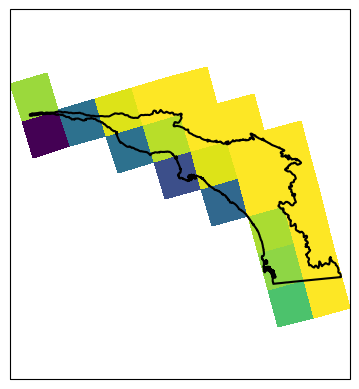

In [59]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

ax.pcolormesh(nam44_clipped.lon, nam44_clipped.lat, nam44_clipped)
baja.boundary.plot(ax = ax, color = "k")

---
# Compile variables & compute FWI

In [3]:
pr = xr.open_dataset(fpath+"era5/era5_pr_1940-2025.nc").pr
pr = pr.assign_attrs(units = "mm d-1", long_name = "Precipitation").rename(latitude = "lat", longitude = "lon")
pr = pr.assign_coords(time = pr.time.dt.floor("D"))
pr.to_netcdf("data/era5_pr.nc")

In [4]:
hurs = xr.open_dataset(fpath+"era5/era5_hurs_1940-2025.nc").hurs
hurs = hurs.assign_attrs(units = "%", long_name = "Relative humidity").rename(latitude = "lat", longitude = "lon")
hurs = hurs.assign_coords(time = hurs.time.dt.floor("D"))
hurs.to_netcdf("data/era5_hurs.nc")

In [5]:
sfcWind = xr.open_dataset(fpath+"era5/era5_sfcWind_1940-2025.nc").sfcWind
sfcWind = sfcWind.assign_attrs(units = "km h-1", long_name = "Wind speed").rename(latitude = "lat", longitude = "lon")
sfcWind = sfcWind.assign_coords(time = sfcWind.time.dt.floor("D"))
sfcWind.to_netcdf("data/era5_sfcWind.nc")

In [6]:
tas = xr.open_dataset(fpath+"era5/era5_tas_1940-2025.nc").tas
tas = tas.assign_attrs(units = "degC", long_name = "Noon temperature").rename(latitude = "lat", longitude = "lon")
tas = tas.assign_coords(time = tas.time.dt.floor("D"))
tas.to_netcdf("data/era5_tas.nc")

In [11]:
from xclim.indicators.atmos import cffwis_indices

ds = xr.merge([pr, hurs, sfcWind, tas])
# mask to land surface only
ds = ds.where(regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds) == 0)

In [ ]:
fwi = cffwis_indices(ds = ds, overwintering = False)

---
# Daily time series from gridded data

## ERA5

In [6]:
for varnm in ["BUI", "DC", "DMC", "DSR", "FFMC", "FWI", "ISI"]:
    da = xr.open_dataset(fpath+"era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
    da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["latitude", "longitude"])
    
    da_ts = da_ts.rename(varnm.lower()).reset_coords(drop = True)
    da_ts.to_netcdf("data/era5_"+varnm.lower()+"_"+rnm+".nc")
    
    

In [8]:
for varnm in ["pr", "tas", "hurs", "sfcWind"]:
    da = xr.open_dataset(fpath+"era5/era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
    da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["latitude", "longitude"])
    
    da_ts = da_ts.rename(varnm).reset_coords(drop = True)
    da_ts.to_netcdf("data/era5_"+varnm+"_"+rnm+".nc")

In [28]:
varnm = "FWI"
da = xr.open_dataset(fpath+"era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
da_rm = da.rio.clip(sf.geometry.values, all_touched = True).rename("fwi")

fwi_max = da_rm.max(["latitude", "longitude"]).rename("fwimax")
fwi_max.to_netcdf("data/era5_fwimax_"+rnm+".nc")

fwi_q95 = da_rm.quantile(.95, dim = ["latitude", "longitude"]).rename("fwiq95")
fwi_q95.to_netcdf("data/era5_fwiq95_"+rnm+".nc")

In [72]:
varnm = "HDWI"
da = xr.open_dataset(fpath+"era5_noon_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
da_rm = da.rio.clip(sf.geometry.values, all_touched = True).rename("hdwi")

da_mean = da_rm.mean(["latitude", "longitude"]).rename("hdwi")
da_mean.to_netcdf("data/era5_hdwi_"+rnm+".nc")

da_max = da_rm.max(["latitude", "longitude"]).rename("hdwimax")
da_max.to_netcdf("data/era5_hdwimax_"+rnm+".nc")

# Time series for analysis

## OND mean precip

In [50]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr

pr_d = pr.resample(time = "MS").sum().rolling(time = 1).mean().groupby("time.month")[12]
pr_d.assign_coords(time = pr_d.time.dt.year).rename("pr_d", time = "year").to_dataframe().to_csv("ts/era5_pr-d_"+rnm+".csv")

pr_nd = pr.resample(time = "MS").sum().rolling(time = 2).mean().groupby("time.month")[12]
pr_nd.assign_coords(time = pr_nd.time.dt.year).rename("pr_nd", time = "year").to_dataframe().to_csv("ts/era5_pr-nd_"+rnm+".csv")

pr_ond = pr.resample(time = "MS").sum().rolling(time = 3).mean().groupby("time.month")[12]
pr_ond.assign_coords(time = pr_ond.time.dt.year).rename("pr_ond", time = "year").to_dataframe().to_csv("ts/era5_pr-ond_"+rnm+".csv")

pr_son = pr.resample(time = "MS").sum().rolling(time = 3).mean().groupby("time.month")[11]
pr_son.assign_coords(time = pr_son.time.dt.year).rename("pr_son", time = "year").to_dataframe().to_csv("ts/era5_pr-son_"+rnm+".csv")

pr_sond = pr.resample(time = "MS").sum().rolling(time = 4).mean().groupby("time.month")[12]
pr_sond.assign_coords(time = pr_sond.time.dt.year).rename("pr_sond", time = "year").to_dataframe().to_csv("ts/era5_pr-sond_"+rnm+".csv")

## OND SPI
Might be better for statistical modelling, but keep conversion parameters to map results back to precip afterwards

In [12]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

pr_m = pr_ond.copy()
pr_cal = pr_m.sel(time = slice("1991", "2020")).copy()
pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

NameError: name 'pr_ond' is not defined

In [10]:
spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)

spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                           gamma_scale = pars.sel(dparams = "scale").values,
                           calibration = "Calibrated against 1991-2020").rename("spi_ond")

spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_spi-ond_"+rnm+".csv")

In [13]:
def quick_spi(fnm):
    
    # load data
    df = pd.read_csv(fnm, index_col = "year")
    da = df.to_xarray()[df.columns[0]].assign_attrs(year = [datetime(y,1,1) for y in df.index]).rename(year = "time")
    
    pr_m = da.copy()
    pr_cal = pr_m.sel(time = slice(1991, 2020)).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
    
    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
    
    spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                           gamma_scale = pars.sel(dparams = "scale").values,
                           calibration = "Calibrated against 1991-2020").rename("spi_"+fnm.split("_")[1][3:])
    
    spi_m.rename(time = "year").to_dataframe().to_csv(re.sub("pr", "spi", fnm))

In [14]:
for fnm in glob.glob("ts/era5_pr-*_"+rnm+".csv"): quick_spi(fnm)

In [16]:
glob.glob("ts/era5_spi-*_"+rnm+".csv")

['ts/era5_spi-son_socal-baja.csv',
 'ts/era5_spi-d_socal-baja.csv',
 'ts/era5_spi-nd_socal-baja.csv',
 'ts/era5_spi-ond_socal-baja.csv',
 'ts/era5_spi-sond_socal-baja.csv']

## FWI indices

In [5]:
ts = xr.open_dataset("data/era5_fwimax_socal-baja.nc").fwimax.reset_coords(drop = True)

ts_max = ts.sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
ts_max.assign_coords(time = ts_max.time.dt.year+1).rename(time = "year").to_dataframe().to_csv("ts/era5_maxfwimax_socal-baja.csv")

In [9]:
ts = xr.open_dataset("data/era5_fwi_socal-baja.nc").fwi

for ndays in [1,2,3,5,7]:
    fwinx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
    fwinx.assign_coords(time = fwinx.time.dt.year).rename("fwi"+str(ndays)+"x", time = "year").to_dataframe().to_csv("ts/era5_fwi"+str(ndays)+"x-dj_socal-baja.csv")

In [12]:
ts = xr.open_dataset("data/era5_dsr_socal-baja.nc").dsr

for ndays in [1,2,3,5,7]:
    dsrnx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
    dsrnx.assign_coords(time = dsrnx.time.dt.year).rename("dsr"+str(ndays)+"x", time = "year").to_dataframe().to_csv("ts/era5_dsr"+str(ndays)+"x-dj_socal-baja.csv")

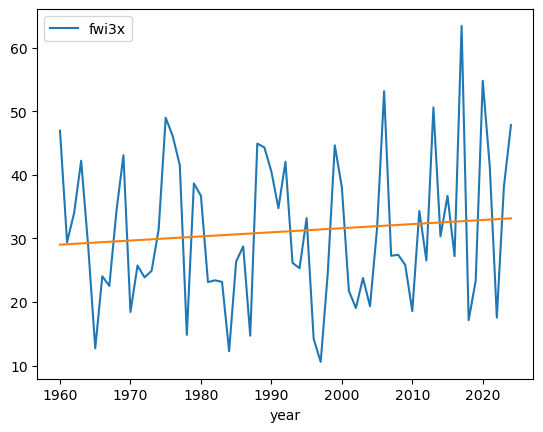

In [11]:
# fairly clear increase since 1960 but if we include 1959 and earlier, there's a big difference
fwi3x = pd.read_csv("ts/era5_fwi3x-dj_socal-baja.csv", index_col = "year")
fwi3x = fwi3x.loc[fwi3x.index >= 1960]

fwi3x.plot()
xyline(fwi3x.index, fwi3x.fwi3x, ax = plt.gca())

# pull out source variables associated with those FWI events and try to identify where this is coming from - is there some inhomogeneity in the data?

# Final time series

In [24]:
# fwi = xr.open_dataset("data/era5_fwi_socal-baja.nc").fwi
# for ndays in [1,3,5,7]:
#     fwinx = fwi.rolling(time = ndays).mean().groupby("time.month")[1].resample(time = "AS-JAN").max().rename("fwi"+str(ndays)+"x")
#     fwinx.assign_coords(time = fwinx.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_fwi"+str(ndays)+"x-jan_socal-baja.csv")

In [79]:
# area-weighted data from Theo
fwi = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/timeseries/FWI_1day_J_ERA5.csv", index_col = "time", parse_dates = ["time"])

fwi.index = fwi.index.year
fwi.index.name = "year"
fwi = fwi.rename(columns = {"J_FWI_1day" : "fwi1x"})

fwi.to_csv("ts/era5_fwi1x-jan_socal-baja.csv")

In [83]:
pr = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/timeseries/PR_daily_totals_ERA5.csv", index_col = "valid_time",  parse_dates = ["valid_time"])
pr = pr.to_xarray().PR.rename("pr", valid_time = "time")

In [87]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

# original data, using generous area selection algorithm - DO NOT USE
# pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr

# area-weighted data from Theo
pr = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/timeseries/PR_daily_totals_ERA5.csv", index_col = "valid_time",  parse_dates = ["valid_time"])
pr = pr.to_xarray().PR.rename("pr", valid_time = "time")

pr_ond = pr.sel(time = pr.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").sum()

pr_cal = pr_ond.sel(time = slice("1991", "2020")).copy()
pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                           gamma_scale = pars.sel(dparams = "scale").values,
                           calibration = "Calibrated against 1991-2020").rename("spi_ond")

spi_m.to_netcdf("data/era5_spi-ond_"+rnm+".nc")
spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_spi-ond_"+rnm+".csv")

In [96]:
gamma.cdf(pr_ond, *pars)

array([0.89940897, 0.67582725, 0.09817945, 0.67062166, 0.62048858,
       0.82033156, 0.93653767, 0.44009514, 0.60624629, 0.74930353,
       0.29272008, 0.83092545, 0.85355131, 0.14319405, 0.26092324,
       0.46835193, 0.03017731, 0.80071538, 0.11520536, 0.32588872,
       0.52234569, 0.77204636, 0.14687887, 0.61345557, 0.56406975,
       0.9886692 , 0.91308704, 0.83462565, 0.36842468, 0.32943095,
       0.87046931, 0.90900846, 0.75687866, 0.35323097, 0.66140302,
       0.20138049, 0.2618221 , 0.43151941, 0.83989961, 0.31215116,
       0.16945161, 0.49928659, 0.8326164 , 0.91534373, 0.8711621 ,
       0.85579581, 0.40973009, 0.91159893, 0.66602641, 0.0835213 ,
       0.15758856, 0.52619825, 0.79524049, 0.40646148, 0.42399018,
       0.1312661 , 0.84283944, 0.80683336, 0.29945904, 0.01778648,
       0.19989964, 0.41242863, 0.68611887, 0.39246492, 0.97891295,
       0.23687343, 0.19141737, 0.40619806, 0.78256284, 0.60731471,
       0.98661929, 0.59455147, 0.49711859, 0.28437251, 0.65521

In [88]:
pars2 = fit(pr_ond.dropna("time", "all"), dist = "gamma", method = "PWM")

spi_2 = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars2, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)


Text(0.5, 0, 'SPI')

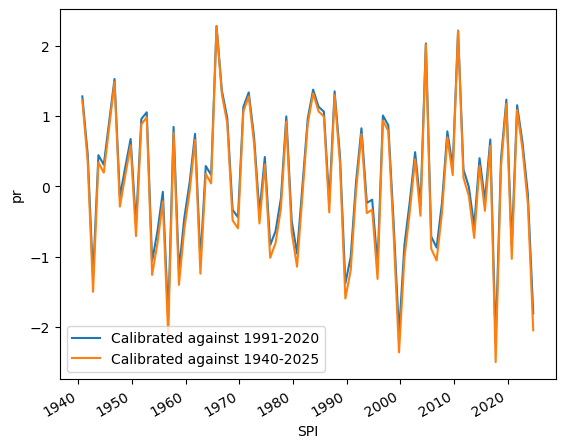

In [89]:
spi_m.plot(label = "Calibrated against 1991-2020")
spi_2.plot(label = "Calibrated against 1940-2025")
plt.legend()
plt.xlabel("SPI")

# CORDEX

## Compile time series

In [48]:
varnm = "FWI_1day_J"

fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/timeseries/"+varnm+"_rcp85*")

for fnm in fl:
    df_rcp = pd.read_csv(fnm, index_col = "time", parse_dates = ["time"])
    df_hist = pd.read_csv(re.sub("rcp85", "hist", fnm), index_col = "time", parse_dates = ["time"])
    
    df = pd.concat([df_hist, df_rcp])
    df.index = df.index.year
    df.index.name = "year"
    df = df.rename(columns = {"J_FWI_1day" : "fwi1x"})
    df.to_csv("ts/NAM-22i_fwi1x_"+"_".join(fnm.split("_")[-5:-3])+".csv")

## Detrended Nino3.4 index

In [103]:
gcm_list = ['CanESM2','EC-EARTH','GFDL-ESM2M','HadGEM2-ES','MPI-ESM-LR','MPI-ESM-MR', "CNRM-CM5", "NorESM1-M"]
for gcm in gcm_list:
    if os.path.exists("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cmip5-nino34/nino34det_cmip5_"+gcm+"_r1i1p1.nc"):
        da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cmip5-nino34/nino34det_cmip5_"+gcm+"_r1i1p1.nc").nino34_det
        ts = da.sel(time = da.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
        ts.to_dataframe().to_csv("ts/nino34det_cmip5_"+gcm+".nc", sep = " ")

## Daily precip time series

In [80]:
import rioxarray as rxr

fl = sorted(glob.glob(fpath+"cordex-data/NAM-*/*/*/*/pr/"))

# need to confirm that these are correct
crs_nam = {"CRCM5": cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'CanRCM4': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'HIRHAM5': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
#            'RCA4', # no precip data
           'REMO2015': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5), 
#            'RegCM4', # ObliqueMercator projection
           'WRF' : cartopy.crs.LambertConformal(central_longitude = -96.0, central_latitude = 46.0, standard_parallels = (35,60),
                                                false_easting = 3700000.0, false_northing = 3500000.0),
          }

for fp in fl:
    
    new_fnm = "data/"+"_".join(fp.split("/")[10:14])+"_pr-daily.nc"
    print(new_fnm)
    
    if os.path.exists(new_fnm): continue
    if new_fnm in ["data/NAM-22_MPI-M-MPI-ESM-LR_r1i1p1_CRCM5_pr-daily.nc"]: continue
        
    rcm = fp.split("/")[-3]
    if not rcm in crs_nam.keys(): continue
    rcm_crs = crs_nam[rcm]
    
    # load dataset
    da = xr.open_mfdataset(sorted(glob.glob(fp+"*.nc")))
    
    if "rlon" in da.dims:
        da = da.rename(rlon ="x", rlat = "y")
        
    sf_rpole = sf.to_crs(rcm_crs)

    # assign CRS & rename dims for mapping
    da = da.pr.reset_coords(drop = True).rio.write_crs(rcm_crs)
    
    # clip to region
    da_clipped = da.rio.clip(sf_rpole.geometry.values, sf_rpole.crs, all_touched = True)
    
    # get time series
    ts = convert_units_to(da_clipped.mean(["x", "y"]), "mm/day").reset_coords(drop = True)
    ts.to_netcdf(new_fnm)

In [82]:
da_list = [xr.open_dataset(fnm) for fnm in sorted(glob.glob(fp+"*.nc"))]

In [ ]:
xr.concat(da_list, "time")

## daily DC time series

In [5]:
import rioxarray as rxr
fl = sorted(glob.glob(fpath+"dc-source/DC-southern-california*.nc"))

In [17]:
# need to confirm that these are correct
crs_nam = {"CRCM5": cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'CanRCM4': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'HIRHAM5': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
#            'RCA4', # no precip data
           'REMO2015': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5), 
#            'RegCM4', # ObliqueMercator projection
           'WRF' : cartopy.crs.LambertConformal(central_longitude = -96.0, central_latitude = 46.0, standard_parallels = (35,60),
                                                false_easting = 3700000.0, false_northing = 3500000.0),
          }

In [18]:
for fnm in fl:
    
    new_fnm = "data/"+"_".join(fnm.split("_")[4:-1])+"_dc-daily.nc"
    print(new_fnm)
    
    if os.path.exists(new_fnm): continue
    
    rcm = fnm.split("_")[-2]
    if not rcm in crs_nam.keys(): continue
    rcm_crs = crs_nam[rcm]
    
    sf_rpole = sf.to_crs(rcm_crs)
    
    # load data, assign CRS & rename dims for mapping
    da = xr.open_dataset(fnm).dc
    if "rlon" in da.dims:
        da = da.rename(rlon ="x", rlat = "y")
    da = da.reset_coords(drop = True).rio.write_crs(rcm_crs)
    
    # clip to region
    da_clipped = da.rio.clip(sf_rpole.geometry.values, sf_rpole.crs, all_touched = True)
    
    # get time series
    ts = da_clipped.mean(["x", "y"]).reset_coords(drop = True)
    ts.to_netcdf(new_fnm)

data/NAM-44_CCCma-CanESM2_r1i1p1_CRCM5_dc-daily.nc
data/NAM-44_CCCma-CanESM2_r1i1p1_CanRCM4_dc-daily.nc
data/NAM-44_MOHC-HadGEM2-ES_r1i1p1_RegCM4_dc-daily.nc
data/NAM-44_MOHC-HadGEM2-ES_r1i1p1_WRF_dc-daily.nc
data/NAM-44_MPI-M-MPI-ESM-LR_r1i1p1_CRCM5_dc-daily.nc
data/NAM-44_MPI-M-MPI-ESM-LR_r1i1p1_RegCM4_dc-daily.nc
data/NAM-44_MPI-M-MPI-ESM-LR_r1i1p1_WRF_dc-daily.nc
data/NAM-44_MPI-M-MPI-ESM-MR_r1i1p1_CRCM5_dc-daily.nc
data/NAM-44_NOAA-GFDL-GFDL-ESM2M_r1i1p1_RegCM4_dc-daily.nc
data/NAM-44_NOAA-GFDL-GFDL-ESM2M_r1i1p1_WRF_dc-daily.nc


### Largest drop in drought code

In [15]:
def hydro_days(ds):
    
    hydro_yrs = []
    for yr in range(int(ds.time.dt.year.min()), int(ds.time.dt.year.max())):
        temp = ds.dc.sel(time = np.logical_or(
            np.logical_and(ds.time.dt.year == yr, ds.time.dt.month >= 9),
            np.logical_and(ds.time.dt.year == yr+1, ds.time.dt.month <= 8)))
#         temp = temp.mean(dim = ['latitude','longitude'])
        hydro_yrs.append(temp)
    
    hydro_doys = []
    for i, data in enumerate(hydro_yrs):
        temp = data.rolling(time = 7).mean()#.resample(time = 'W').mean()
        drop = list([np.nan]*7) + list(temp.data[7:] - temp.data[:-7])
        min_arg = np.nanargmin(drop)
        doy_hydro = int(temp.time[min_arg].dt.dayofyear)
        start_doy = int(data.time[0].dt.dayofyear)
        if doy_hydro >= start_doy:
            output = doy_hydro - start_doy
        else:
            eoy = pd.to_datetime(f'{int(temp.time.dt.year[0])}-12-31').dayofyear
            output = (eoy - start_doy) + doy_hydro
        hydro_doys.append(output)

    yrs = np.arange(int(ds.time.dt.year.min()), int(ds.time.dt.year.max()))
    
    df = pd.DataFrame(
        np.array([yrs, hydro_doys]).T,
        columns = ["year", "dc_doy"])
    return df

In [23]:
gcm_names = {'CNRM-CERFACS-CNRM-CM5':"CNRM-CM5",
             'MOHC-HadGEM2-ES':"HadGEM2-ES",
             'MPI-M-MPI-ESM-LR':"MPI-ESM-LR",
             'MPI-M-MPI-ESM-MR':"MPI-ESM-MR",
             'NCC-NorESM1-M':"NorESM1-M",
             'NOAA-GFDL-GFDL-ESM2M':"GFDL-ESM2M",
             'CCCma-CanESM2':"CanESM2",
             'ICHEC-EC-EARTH':"EC-EARTH"}

In [17]:
fl = sorted(glob.glob(fpath+"dc-source/DC-southern-california*.nc"))[:1]

In [18]:
for fnm in fl:
    da = xr.open_dataset(fl[0]).dc
    
    if "rlon" in da.dims:
        dc = da.mean(["rlat", "rlon"])
    else:
        dc = da.mean(["x", "y"])

In [76]:
for fnm in fl:
    
#     if fnm in ['data/NAM-44_CCCma-CanESM2_r1i1p1_CRCM5_pr-daily.nc']:
#         print("-")
#         continue
        
    gcm = fnm.split("_")[-4]
    new_fnm = re.sub(gcm, gcm_names[gcm], "ts/cordex_dc7-doy_"+fnm[5:-12]+".csv")
    print(new_fnm)
    if os.path.exists(new_fnm): continue
    
    dc = convert_calendar(xr.open_dataset(fnm), "default").dropna("time", "any")
    df = hydro_days(dc).set_index("year")
    df.to_csv(new_fnm)

## OND proportion & drought onset timing

In [29]:
gcm_names = {'CNRM-CERFACS-CNRM-CM5':"CNRM-CM5",
             'MOHC-HadGEM2-ES':"HadGEM2-ES",
             'MPI-M-MPI-ESM-LR':"MPI-ESM-LR",
             'MPI-M-MPI-ESM-MR':"MPI-ESM-MR",
             'NCC-NorESM1-M':"NorESM1-M",
             'NOAA-GFDL-GFDL-ESM2M':"GFDL-ESM2M",
             'CCCma-CanESM2':"CanESM2",
             'ICHEC-EC-EARTH':"EC-EARTH"}

In [32]:
fl = sorted(glob.glob("data/NAM*_pr-daily.nc"))

In [37]:
for fnm in fl:
    
#     if fnm in ['data/NAM-44_CCCma-CanESM2_r1i1p1_CRCM5_pr-daily.nc']:
#         print("-")
#         continue
        
    gcm = fnm.split("_")[1]
    new_fnm = re.sub(gcm, gcm_names[gcm], "ts/cordex_doy-clim30pc_"+fnm[5:-12]+".csv")
    print(new_fnm, end = ": ")
    
    pr = convert_calendar(xr.open_dataset(fnm).pr, "default", align_on = "date")
    pr_clim = pr.resample(time = "AS-OCT").sum().sel(time = slice("1990", "2019")).mean()
    pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = -92).data))
    
    prop_ond = (pr.sel(time = pr.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").sum() / pr_clim).mean()
    print(prop_ond.values)

    doy = pr.offset_time.dt.dayofyear.where(pr.resample(time = "AS-OCT").cumsum() >= (0.30 * pr_clim)).dropna("time", "any").resample(time = "AS-OCT").min()
    doy = doy.assign_coords(time = doy.time.dt.year+1).rename(time = "year")
    
    doy.to_dataframe().to_csv(new_fnm)

ts/cordex_doy-clim30pc_NAM-22_CNRM-CM5_r1i1p1_CRCM5.csv: 0.3160197
ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_REMO2015.csv: 0.31253123
ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_WRF.csv: 0.35341305
ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-LR_r1i1p1_REMO2015.csv: 0.26497677
ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-LR_r1i1p1_WRF.csv: 0.2639446
ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-MR_r1i1p1_CRCM5.csv: 0.2718925
ts/cordex_doy-clim30pc_NAM-22_NorESM1-M_r1i1p1_REMO2015.csv: 0.3108272
ts/cordex_doy-clim30pc_NAM-22_GFDL-ESM2M_r1i1p1_CRCM5.csv: 0.26315978
ts/cordex_doy-clim30pc_NAM-22_GFDL-ESM2M_r1i1p1_WRF.csv: 0.28400254
ts/cordex_doy-clim30pc_NAM-44_CanESM2_r1i1p1_CRCM5.csv: 0.27297726
ts/cordex_doy-clim30pc_NAM-44_CanESM2_r1i1p1_CanRCM4.csv: 0.24618974
ts/cordex_doy-clim30pc_NAM-44_EC-EARTH_r3i1p1_HIRHAM5.csv: 0.32168436
ts/cordex_doy-clim30pc_NAM-44_HadGEM2-ES_r1i1p1_WRF.csv: 0.3450511


## OND SPI

In [85]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

### CORDEX

In [85]:
fl = sorted(glob.glob("data/NAM*_pr-daily.nc"))

In [6]:
gcm_names = {'CNRM-CERFACS-CNRM-CM5':"CNRM-CM5",
             'MOHC-HadGEM2-ES':"HadGEM2-ES",
             'MPI-M-MPI-ESM-LR':"MPI-ESM-LR",
             'MPI-M-MPI-ESM-MR':"MPI-ESM-MR",
             'NCC-NorESM1-M':"NorESM1-M",
             'NOAA-GFDL-GFDL-ESM2M':"GFDL-ESM2M",
             'CCCma-CanESM2':"CanESM2",
             'ICHEC-EC-EARTH':"EC-EARTH"}

In [117]:
for fnm in fl:
    pr = xr.open_dataset(fnm).pr
    if np.isnan(pr.max()): continue
        
    gcm = fnm.split("_")[1]
    new_fnm = re.sub(gcm, gcm_names[gcm], "data/spi-ond_"+fnm.split("/")[1][:-12]+".nc")
    
    pr_ond = pr.sel(time = pr.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()
    
    pr_cal = pr_ond.sel(time = slice("1991", "2020")).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                                   input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

    spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                               gamma_scale = pars.sel(dparams = "scale").values,
                               calibration = "Calibrated against 1991-2020").rename("spi_ond")
    
    spi_m.to_netcdf(new_fnm)
    spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv(re.sub("nc", "csv", re.sub("data", "ts", new_fnm)))

### HighResMIP

In [11]:
fl = sorted(glob.glob("data/pr-ond_IPSL*.nc"))

In [60]:
for fnm in fl:
    
    new_fnm = re.sub("pr-ond", "spi-ond", fnm)
    if os.path.exists(new_fnm): continue
    
    # load data, get area-weighted mean
    da = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    pr_ond = awmean(da).reset_coords(drop = True)
    
    pr_cal = pr_ond.sel(time = slice("1980", "2010")).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                                   input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

    spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                               gamma_scale = pars.sel(dparams = "scale").values,
                               calibration = "Calibrated against 1981-2010").rename("spi_ond")
    
    spi_m.to_netcdf(new_fnm)
    spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv(re.sub("nc", "csv", re.sub("data", "ts", new_fnm)))

# Compute drought code from CORDEX data

In [3]:
from xclim.indicators.atmos import drought_code

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/dc-source/"

xn,xx,yn,yx = [-121,-116,32.5,34.6]

In [4]:
gcm_names = {'CNRM-CERFACS-CNRM-CM5':"CNRM-CM5",
             'MOHC-HadGEM2-ES':"HadGEM2-ES",
             'MPI-M-MPI-ESM-LR':"MPI-ESM-LR",
             'MPI-M-MPI-ESM-MR':"MPI-ESM-MR",
             'NCC-NorESM1-M':"NorESM1-M",
             'NOAA-GFDL-GFDL-ESM2M':"GFDL-ESM2M",
             'CCCma-CanESM2':"CanESM2",
             'ICHEC-EC-EARTH':"EC-EARTH"}

In [5]:
fl = sorted(glob.glob(fpath+"pr_daily*.nc"))

In [7]:
for fnm in fl:
    
    mdl = "_".join(fnm.split("_")[-5:-1])
    print(mdl, end = " ")
    
    if mdl in ["NAM-44_ICHEC-EC-EARTH_r3i1p1_HIRHAM5"]:
        print("Model hang")
        continue
    
    new_fnm = fpath+"dc-daily_"+re.sub(fnm.split("_")[-4], gcm_names[fnm.split("_")[-4]], mdl)
    if len(glob.glob(new_fnm+"*.nc")) > 0: 
        print("")
        continue

    tmax_fnm = glob.glob(fpath+"tasmax_daily_"+mdl+"*.nc")
    if len(tmax_fnm) == 0: 
        print("No tasmax")
        continue
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pr = xr.open_dataset(fnm).pr.dropna("time", "any")

    if "rlat" in pr.dims:
        xdim, ydim = ["rlat", "rlon"]
    else:
        xdim, ydim = ["x", "y"]
    
    tmax = xr.open_dataset(tmax_fnm[0]).tasmax.drop_duplicates("time", keep = "first")
    
    rm = np.logical_and(np.logical_and(pr.lon >= xn, pr.lon <= xx), np.logical_and(pr.lat >= yn, pr.lat <= yx))
    rm = rm.where(rm == 1).dropna(xdim, "all").dropna(ydim, "all")
    
    pr = pr.sel({xdim : rm[xdim], ydim : rm[ydim]})
    tmax = tmax.sel({xdim : rm[xdim], ydim : rm[ydim]})
    
    pr = convert_units_to(pr, "mm/day")
    tmax = convert_units_to(tmax, "degC")
    
    pr = pr.resample(time = "D").mean()
    tmax = tmax.resample(time = "D").mean()
    
    dc = drought_code(ds = xr.merge([tmax.rename("tas"), pr])).dropna("time", "any")
    
    new_fnm = new_fnm + "_"+str(dc.time[0].dt.year.values) + "-" + str(dc.time[-1].dt.year.values) + ".nc"
    dc.to_netcdf(new_fnm)
    print("")
    
clear_output(wait = False)
print("Done.")

Done.


### DC time series

In [5]:
fl = sorted(glob.glob(fpath+"dc-source/dc-daily_*.nc"))

In [6]:
# need to confirm that these are correct
crs_nam = {"CRCM5": cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'CanRCM4': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
           'HIRHAM5': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5),
#            'RCA4', # no precip data
           'REMO2015': cartopy.crs.RotatedPole(pole_longitude = 83.0, pole_latitude = 42.5), 
           'RegCM4': cartopy.crs.TransverseMercator(central_longitude=263.0, central_latitude=46.0),
           'WRF' : cartopy.crs.LambertConformal(central_longitude = -96.0, central_latitude = 46.0, standard_parallels = (35,60),
                                                false_easting = 3700000.0, false_northing = 3500000.0),
          }

In [7]:
# extract area-weighted time series
for fnm in fl:
    
    print(fnm)
    
    da = xr.open_dataset(fnm).dc
    rcm_crs = crs_nam[fnm.split("_")[-2]]
    rcm_sf = sf.to_crs(rcm_crs)
    
    if "rlat" in da.dims: da = da.rename(rlat = "y", rlon = "x")
        
    ts = awmean(da, rcm_sf, rcm_crs)
    ts.to_netcdf(re.sub("daily", "awdaily", fnm))
    
clear_output(wait = False)

In [8]:
fl = sorted(glob.glob(fpath+"dc-source/dc-awdaily_*.nc"))

In [33]:
for fnm in fl:
    
    print(fnm.split("/")[-1], end = " ")
    
    new_fnm = "ts/cordex_dc7-doy_"+"_".join(fnm.split("_")[-5:-1])+".csv"
    if os.path.exists(new_fnm): 
        print("")
        continue
        
    da = xr.open_dataset(fnm)
    ts = hydro_days(da)
    
    # save the file as is
    print(ts.dc_doy.max(), end = " ")
    ts.to_csv(new_fnm)
    
    # wrap at 300 days and save again - otherwise DOY getting earlier will be coded as more high values, & trend will go in wrong direction
    # check of new max DOY suggests that after wrapping values > 300, max value is close to 200 (one model has 258), suggesting that this is an appropriate seasonal break
    ts.loc[ts.dc_doy > 300] = ts.loc[ts.dc_doy > 300] - 365
    ts.to_csv(re.sub("dc7-doy", "dc7-doy-wrapped", new_fnm))
    print(ts.dc_doy.max(), end = " ")
    
    print("")
    

dc-awdaily_NAM-22_GFDL-ESM2M_r1i1p1_CRCM5_1950-2100.nc 
dc-awdaily_NAM-22_GFDL-ESM2M_r1i1p1_WRF_1950-1991.nc 
dc-awdaily_NAM-44_CanESM2_r1i1p1_CRCM5_1950-2100.nc 
dc-awdaily_NAM-44_CanESM2_r1i1p1_CanRCM4_1950-2100.nc 
dc-awdaily_NAM-44_GFDL-ESM2M_r1i1p1_RegCM4_1950-2099.nc 
dc-awdaily_NAM-44_GFDL-ESM2M_r1i1p1_WRF_1950-1991.nc 
dc-awdaily_NAM-44_HadGEM2-ES_r1i1p1_RegCM4_1950-2099.nc 
dc-awdaily_NAM-44_HadGEM2-ES_r1i1p1_WRF_1950-1969.nc 
dc-awdaily_NAM-44_MPI-ESM-LR_r1i1p1_CRCM5_1949-2100.nc 
dc-awdaily_NAM-44_MPI-ESM-LR_r1i1p1_RegCM4_1949-2099.nc 
dc-awdaily_NAM-44_MPI-ESM-LR_r1i1p1_WRF_1950-1991.nc 
dc-awdaily_NAM-44_MPI-ESM-MR_r1i1p1_CRCM5_1949-2100.nc 


# nclimgrid SPI

In [42]:
pr = xr.open_dataset(fpath+"nclimgrid_prcp.nc").prcp
pr = pr.rio.write_crs("EPSG:4326")
pr_clipped = pr.rio.clip(sf.geometry.values, sf.crs, all_touched = True)

In [46]:
pr_ond = pr_clipped.sel(time = pr_clipped.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean().mean(["lat", "lon"])

In [51]:
pr_cal = pr_ond.sel(time = slice("1991", "2020")).copy()
pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                           gamma_scale = pars.sel(dparams = "scale").values,
                           calibration = "Calibrated against 1991-2020").rename("spi_ond")

In [58]:
spi_m.to_netcdf("data/ngridclim_spi-ond_socal-baja.nc")
spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/ngridclim_spi-ond_socal-baja.csv")

In [55]:
new_fnm

'ts/cordex_dc7-doy_NAM-44_MPI-ESM-MR_r1i1p1_CRCM5.csv'

# HighResMIP from Synda

## SPI-OND

In [73]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/highresmip/pr/cutdata/pr_*.nc")

In [75]:
for fnm in fl:
    
    new_fnm = "data/spi-ond_highresSST_"+fnm.split("_")[5]+"_"+fnm.split("_")[7]+".nc"
    print(new_fnm)
    if os.path.exists(new_fnm): continue
        
    pr = xr.open_dataset(fnm).pr
    pr_ts = awmean(pr, to_sf = sf, da_crs = "EPSG:4326")

    pr_ond = pr_ts.sel(time = pr_ts.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()

    pr_cal = pr_ond.sel(time = slice("1991", "2020")).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                                   input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

    spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                               gamma_scale = pars.sel(dparams = "scale").values,
                               calibration = "Calibrated against 1991-2020").rename("spi_ond")

    spi_m.to_netcdf(new_fnm)
    spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv(re.sub("data", "ts", re.sub("nc","csv", new_fnm)))

data/spi-ond_highresSST_CMCC-CM2-VHR4_r1i1p1f1.nc
data/spi-ond_highresSST_MRI-AGCM3-2-S_r1i1p1f1.nc
data/spi-ond_highresSST_MRI-AGCM3-2-H_r1i1p1f1.nc


# HighResMIP from JASMIN

## SPI-OND

In [94]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/highresmip/la-fires_pr_day_*.nc")

In [95]:
for fnm in fl:
    
    new_fnm = "data/spi-ond_highresSST_"+fnm.split("_")[6]+"_"+fnm.split("_")[8]+".nc"
    print(new_fnm)
    if os.path.exists(new_fnm): continue
        
    pr = xr.open_dataset(fnm).pr
    pr_ts = awmean(pr, to_sf = sf, da_crs = "EPSG:4326")
    pr_ts = pr_ts.sortby("time").drop_duplicates("time")

    pr_ond = pr_ts.sel(time = pr_ts.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()

    pr_cal = pr_ond.sel(time = slice("1991", "2020")).copy()
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_ond, pars, 
                                   input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_ond.time)

    spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                               gamma_scale = pars.sel(dparams = "scale").values,
                               calibration = "Calibrated against 1991-2020").rename("spi_ond")

    spi_m.to_netcdf(new_fnm)
    spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv(re.sub("data", "ts", re.sub("nc","csv", new_fnm)))

data/spi-ond_highresSST_CNRM-CM6-1_r1i1p1f2.nc
data/spi-ond_highresSST_CNRM-CM6-1-HR_r1i1p1f2.nc
data/spi-ond_highresSST_CNRM-CM6-1-HR_r1i1p1f2.nc
data/spi-ond_highresSST_HadGEM3-GC31-HM_r1i1p1f1.nc
data/spi-ond_highresSST_HadGEM3-GC31-LM_r1i14p1f1.nc
data/spi-ond_highresSST_CMCC-CM2-HR4_r1i1p1f1.nc
data/spi-ond_highresSST_HadGEM3-GC31-MM_r1i1p1f1.nc
data/spi-ond_highresSST_EC-Earth3P_r1i1p1f1.nc
data/spi-ond_highresSST_EC-Earth3P_r1i1p1f1.nc
data/spi-ond_highresSST_MPI-ESM1-2-HR_r1i1p1f1.nc
data/spi-ond_highresSST_MPI-ESM1-2-XR_r1i1p1f1.nc
data/spi-ond_highresSST_HadGEM3-GC31-HM_r1i1p1f1.nc
data/spi-ond_highresSST_MPI-ESM1-2-HR_r1i1p1f1.nc


## Drought code & drought onset

In [192]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/highresmip/la-fires_tasmax_day_*.nc")

In [193]:
# get gridded drought code data
for fnm in fl:
    
    new_fnm = "data/dc_highresSST_"+fnm.split("_")[6]+"_"+fnm.split("_")[8]+".nc"
    print(new_fnm)

    if os.path.exists(new_fnm): continue
    
    # where data was originally on 360-day calendar, fill missing days with preceding value - essentially persistence
    tmax = xr.open_dataset(fnm).tasmax.drop_duplicates("time").resample(time = "D").mean().ffill("time")
    pr = xr.open_dataset(re.sub("tasmax", "pr", fnm)).pr.drop_duplicates("time").resample(time = "D").mean().ffill("time")
    
    dc = drought_code(ds = xr.merge([tmax.rename("tas"), pr])).dropna("time", "any")
    dc.to_netcdf(new_fnm)

data/dc_highresSST_MPI-ESM1-2-XR_r1i1p1f1.nc
data/dc_highresSST_MPI-ESM1-2-HR_r1i1p1f1.nc
data/dc_highresSST_HadGEM3-GC31-LM_r1i14p1f1.nc


/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable has a non-conforming cell_methods: Got `area: mean time: maximum`, which do not include the expected `time: mean`
  _check_cell_methods(


data/dc_highresSST_HadGEM3-GC31-MM_r1i1p1f1.nc
data/dc_highresSST_EC-Earth3P_r1i1p1f1.nc
data/dc_highresSST_HadGEM3-GC31-HM_r1i1p1f1.nc
data/dc_highresSST_CNRM-CM6-1_r1i1p1f2.nc


/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable has a non-conforming cell_methods: Got `area: mean time: maximum`, which do not include the expected `time: mean`
  _check_cell_methods(


In [194]:
# get sw time series & drought onset
fl = glob.glob("data/dc_highresSST_*.nc")

In [195]:
def hydro_days(ds):
    
    hydro_yrs = []
    for yr in range(int(ds.time.dt.year.min()), int(ds.time.dt.year.max())):
        temp = ds.sel(time = np.logical_or(
            np.logical_and(ds.time.dt.year == yr, ds.time.dt.month >= 9),
            np.logical_and(ds.time.dt.year == yr+1, ds.time.dt.month <= 8)))
#         temp = temp.mean(dim = ['latitude','longitude'])
        hydro_yrs.append(temp)
    
    hydro_doys = []
    for i, data in enumerate(hydro_yrs):
        temp = data.rolling(time = 7).mean()#.resample(time = 'W').mean()
        drop = list([np.nan]*7) + list(temp.data[7:] - temp.data[:-7])
        min_arg = np.nanargmin(drop)
        doy_hydro = int(temp.time[min_arg].dt.dayofyear)
        start_doy = int(data.time[0].dt.dayofyear)
        if doy_hydro >= start_doy:
            output = doy_hydro - start_doy
        else:
            eoy = pd.to_datetime(f'{int(temp.time.dt.year[0])}-12-31').dayofyear
            output = (eoy - start_doy) + doy_hydro
        hydro_doys.append(output)

    yrs = np.arange(int(ds.time.dt.year.min()), int(ds.time.dt.year.max()))
    
    df = pd.DataFrame(
        np.array([yrs, hydro_doys]).T,
        columns = ["year", "dc_doy"])
    df = df.set_index("year")
    return df

In [196]:
for fnm in fl:
    
    new_fnm = re.sub("nc", "csv", re.sub("data", "ts", re.sub("dc", "dc-doy", fnm)))
    print(new_fnm, end = " ")
    if os.path.exists(new_fnm):
        print("")
        continue
    
    dc = xr.open_dataset(fnm).dc
    dc_ts = awmean(dc.rename(lat = "y", lon = "x"), sf)
    ts = hydro_days(dc_ts)
    
    # save the file as is
    print(ts.dc_doy.max(), end = " ")
    ts.to_csv(new_fnm)
    
    # wrap at 300 days and save again - otherwise DOY getting earlier will be coded as more high values, & trend will go in wrong direction
    # check of new max DOY suggests that after wrapping values > 300, max value is close to 200 (one model has 258), suggesting that this is an appropriate seasonal break
    ts.loc[ts.dc_doy > 300] = ts.loc[ts.dc_doy > 300] - 365
    ts.to_csv(re.sub("dc-doy", "dc-doy-wrapped", new_fnm))
    print(ts.dc_doy.max(), end = " ")
    
    print("")

ts/dc-doy_highresSST_EC-Earth3P_r1i1p1f1.csv 
ts/dc-doy_highresSST_CNRM-CM6-1_r1i1p1f2.csv 
ts/dc-doy_highresSST_MPI-ESM1-2-XR_r1i1p1f1.csv 
ts/dc-doy_highresSST_MPI-ESM1-2-HR_r1i1p1f1.csv 
ts/dc-doy_highresSST_HadGEM3-GC31-LM_r1i14p1f1.csv 364 184 
ts/dc-doy_highresSST_HadGEM3-GC31-MM_r1i1p1f1.csv 196 196 
ts/dc-doy_highresSST_HadGEM3-GC31-HM_r1i1p1f1.csv 208 208 
